# News-Stock Correlation Analysis & Prediction

This notebook performs a comprehensive analysis of the relationship between news sentiment and stock price movements. It includes:

1. **Data Preparation**: Aligning news and stock data
2. **Sentiment Analysis**: Using NLTK VADER to score headlines
3. **Correlation Analysis**: Statistical tests (Pearson, Spearman) and lagged effects
4. **Predictive Modeling**: Training ML models to predict stock movement from sentiment
5. **Model Evaluation**: Assessing performance with advanced metrics

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path
sys.path.append(os.path.abspath(os.path.join('..')))

# Import custom modules
from src.fnsa.data.alignment import normalize_dates, merge_news_stock_data, prepare_ml_features, validate_date_alignment
from src.fnsa.features.sentiment import setup_nltk_resources, batch_sentiment_analysis, aggregate_daily_sentiment
from src.fnsa.features.stock_metrics import calculate_daily_returns, calculate_volatility, create_target_variable
from src.fnsa.analysis.correlation import calculate_pearson_correlation, calculate_lagged_correlation
from src.fnsa.models.sentiment_model import SentimentStockPredictor
from src.fnsa.models.evaluator import evaluate_classification_model, cross_validate_model
from src.fnsa.models.model_saver import save_model
from src.fnsa.utils.plotting import PlotHelper
from src.fnsa.data.preprocessing import convert_to_datetime, handle_missing_values, remove_duplicates


# Initialize plotter
plotter = PlotHelper()

# Download NLTK resources
setup_nltk_resources()

## 1. Data Loading and Preparation

In [2]:
# Load Data
try:
    news_df = pd.read_csv('../data/raw/raw_analyst_ratings.csv')
    print(f"Loaded {len(news_df)} news items")
    
    # Load stock data (example for AAPL)
    stock_df = pd.read_csv('../data/raw/AAPL.csv')
    print(f"Loaded {len(stock_df)} stock records for AAPL")
    
except FileNotFoundError:
    print("Error: Data files not found. Please ensure data is in ../data/raw/")

# Normalize Dates
news_df = convert_to_datetime(news_df, 'date')
news_df = handle_missing_values(news_df, strategy='drop')
news_df = remove_duplicates(news_df)

stock_df = convert_to_datetime(stock_df, 'Date')
stock_df = handle_missing_values(stock_df, strategy='drop')
stock_df = remove_duplicates(stock_df)

print("\nDate ranges:")
print(f"News: {news_df['date'].min()} to {news_df['date'].max()}")
print(f"Stock: {stock_df['Date'].min()} to {stock_df['Date'].max()}")

Loaded 1407328 news items
Loaded 3774 stock records for AAPL

Date ranges:
News: 2011-04-28 01:01:48+00:00 to 2020-06-11 21:12:35+00:00
Stock: 2009-01-02 00:00:00+00:00 to 2023-12-29 00:00:00+00:00


## 2. Sentiment Analysis

We use NLTK's VADER analyzer to compute sentiment scores for each headline.

In [3]:
# Filter news for AAPL
aapl_news = news_df[news_df['stock'] == 'AAPL'].copy()
print(f"Processing {len(aapl_news)} headlines for AAPL...")

# Analyze sentiment (taking a sample to speed up demo if needed)
# aapl_news = aapl_news.head(1000)  # Uncomment for quick testing

sentiment_scores = batch_sentiment_analysis(aapl_news['headline'])
aapl_news = pd.concat([aapl_news.reset_index(drop=True), sentiment_scores], axis=1)

# Aggregate by day
daily_sentiment = aggregate_daily_sentiment(aapl_news, date_col='date', ticker_col='stock')

print("\nDaily Sentiment Sample:")
daily_sentiment.head()

Processing 10 headlines for AAPL...

Daily Sentiment Sample:


,date,stock,avg_sentiment,sentiment_std,news_count,pos_mean,neg_mean,neu_mean
0,2020-06-09 15:11:34+00:00,AAPL,0.4404,NaN,1,0.135,0.0,0.865
1,2020-06-09 16:41:02+00:00,AAPL,0.5472,NaN,1,0.153,0.0,0.847
2,2020-06-09 17:58:46+00:00,AAPL,0.0000,NaN,1,0.000,0.0,1.000
3,2020-06-09 19:14:07+00:00,AAPL,0.0000,NaN,1,0.000,0.0,1.000
4,2020-06-10 04:52:01+00:00,AAPL,0.0516,NaN,1,0.118,0.0,0.882


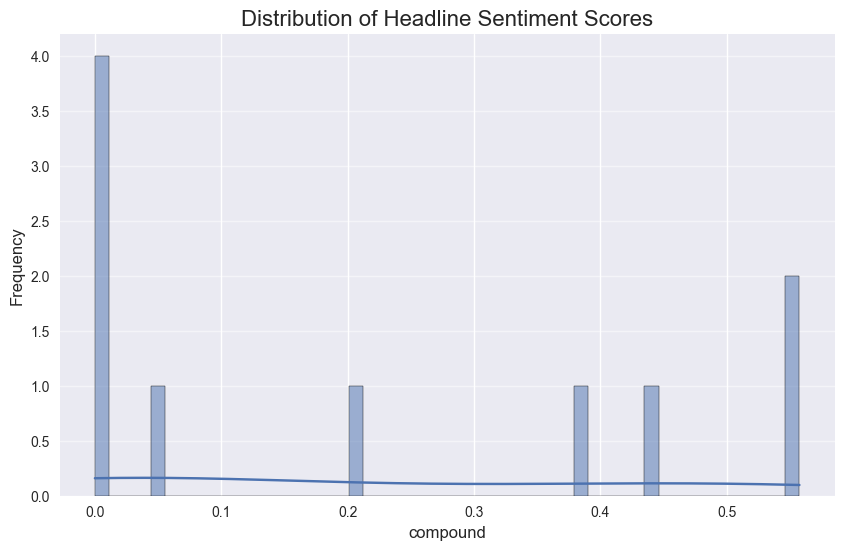

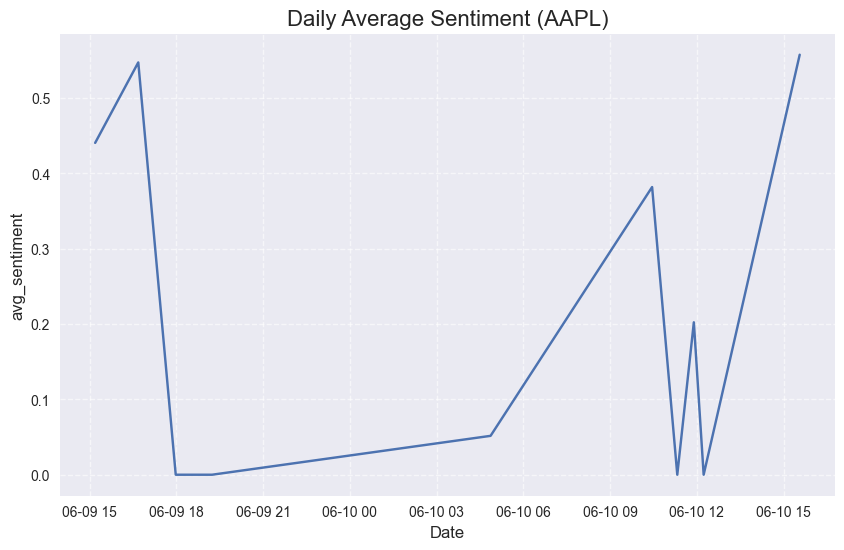

In [4]:
# Visualize Sentiment Distribution
plotter.histogram(aapl_news, column='compound', bins=50, title='Distribution of Headline Sentiment Scores')

# Sentiment over time
plotter.line(daily_sentiment, x='date', y='avg_sentiment', title='Daily Average Sentiment (AAPL)')

## 3. Correlation Analysis

Merging sentiment data with stock returns to find correlations.

In [5]:
# Calculate Returns
stock_df['daily_return'] = calculate_daily_returns(stock_df)

# Merge Data
merged_df = merge_news_stock_data(daily_sentiment, stock_df, 'AAPL', news_date_col='date', stock_date_col='Date')

# Check alignment
stats = validate_date_alignment(merged_df)
print("Alignment Stats:", stats)

# Calculate Correlation
corr_result = calculate_pearson_correlation(merged_df['avg_sentiment'], merged_df['daily_return'])
print(f"\nCorrelation (Sentiment vs Returns): {corr_result['correlation']:.4f}")
print(f"P-value: {corr_result['p_value']:.4f}")
print(f"Significant: {corr_result['significant']}")

Alignment Stats: {'total_rows': 3774, 'rows_with_news': np.int64(0), 'rows_without_news': np.int64(3774), 'date_range': '0 to 3773', 'missing_sentiment_pct': np.float64(100.0)}

Correlation (Sentiment vs Returns): nan
P-value: nan
Significant: False



Lagged Correlations:
   lag  correlation  p_value  significant  n_samples
0    0          NaN      NaN        False       3773
1    1          NaN      NaN        False       3773
2    2          NaN      NaN        False       3772
3    3          NaN      NaN        False       3771
4    4          NaN      NaN        False       3770
5    5          NaN      NaN        False       3769


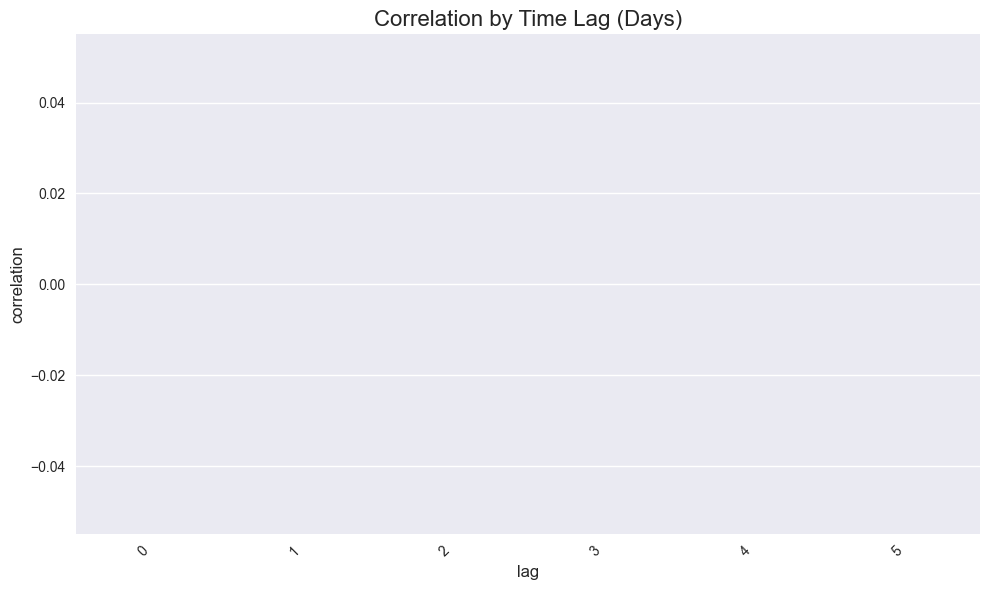

In [6]:
# Lagged Correlation Analysis
lagged_corr = calculate_lagged_correlation(merged_df['avg_sentiment'], merged_df['daily_return'], max_lag=5)

print("\nLagged Correlations:")
print(lagged_corr)

# Visualize Lagged Correlation
plotter.bar(lagged_corr, x='lag', y='correlation', title='Correlation by Time Lag (Days)')

## 4. Predictive Modeling

Training a Machine Learning model to predict stock movement direction based on sentiment features.

In [7]:
# Prepare Features and Target
X, y = prepare_ml_features(merged_df)

print(f"Feature shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

# Split Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Model
predictor = SentimentStockPredictor(model_type='random_forest', hyperparameters={'n_estimators': 200, 'max_depth': 10})
train_info = predictor.train(X_train, y_train)

print("\nTraining Info:", train_info)

Feature shape: (3774, 6)
Target distribution:
daily_return
1    0.530737
0    0.469263
Name: proportion, dtype: float64

Training Info: {'model_type': 'random_forest', 'n_samples': 3019, 'n_features': 6, 'features': ['avg_sentiment', 'sentiment_std', 'news_count', 'pos_mean', 'neg_mean', 'neu_mean']}


## 5. Model Evaluation

Model Performance:
accuracy: 0.5192
precision: 0.5192
recall: 1.0000
f1_score: 0.6835
roc_auc: 0.5000


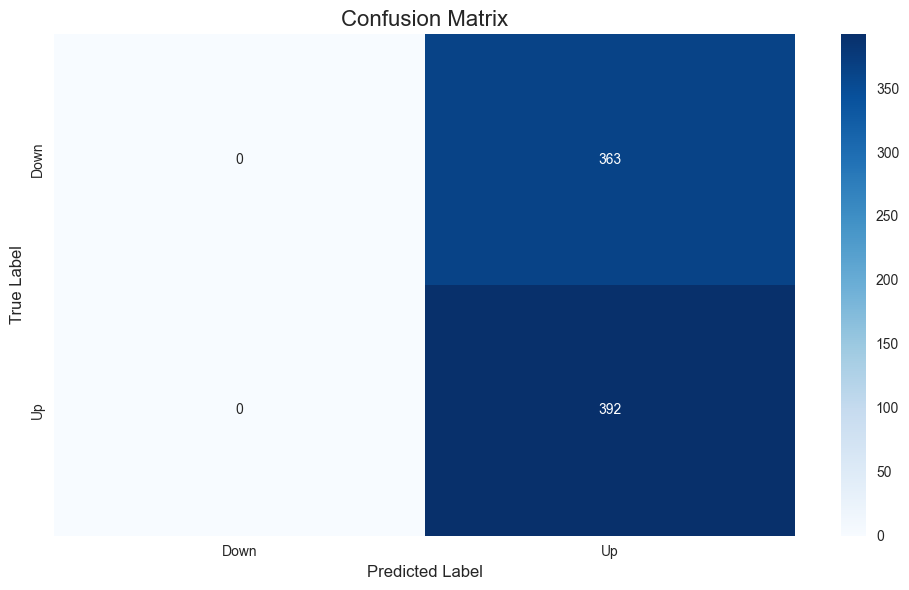

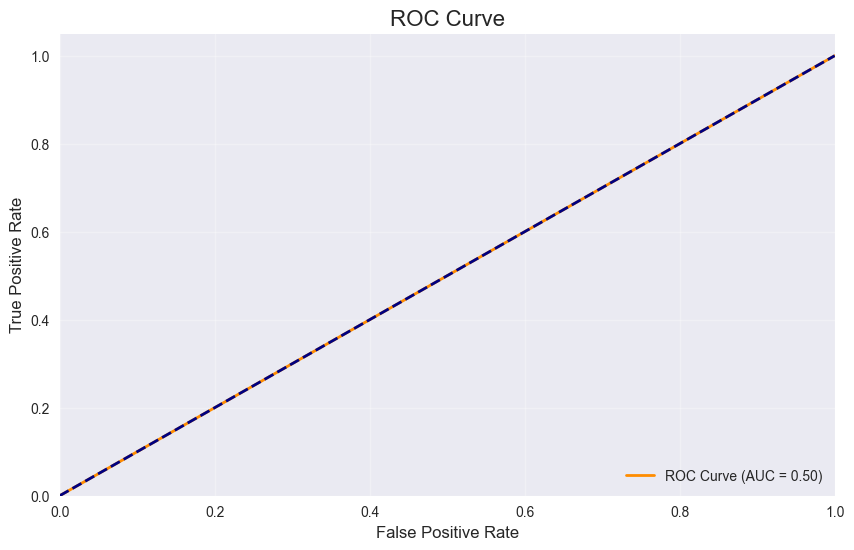

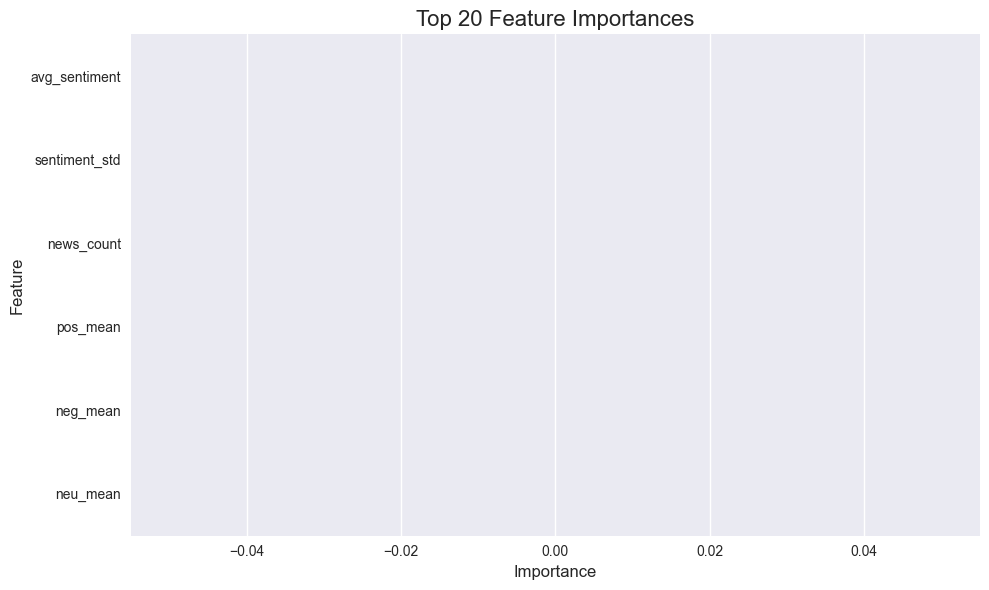

In [8]:
# Predictions
y_pred = predictor.predict(X_test)
y_proba = predictor.predict_proba(X_test)

# Evaluate
metrics = evaluate_classification_model(y_test, y_pred, y_proba)

print("Model Performance:")
for k, v in metrics.items():
    if k != 'confusion_matrix':
        print(f"{k}: {v:.4f}")

# Visualizations
plotter.plot_confusion_matrix(np.array(metrics['confusion_matrix']), labels=['Down', 'Up'])

if metrics['roc_auc']:
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    plotter.plot_roc_curve(fpr, tpr, metrics['roc_auc'])

# Feature Importance
importance_df = predictor.get_feature_importance()
plotter.plot_feature_importance(importance_df['feature'], importance_df['importance'])

## 6. Save Model

In [9]:
# Save the trained model
save_path = save_model(
    predictor.pipeline, 
    base_path='../models/trained', 
    model_name='sentiment_rf_v1', 
    metadata={'metrics': {k: v for k, v in metrics.items() if k != 'confusion_matrix'}}
)

Model saved to ../models/trained\sentiment_rf_v1_20251125_211630.joblib
Metadata saved to ../models/trained\sentiment_rf_v1_20251125_211630_meta.json
